In [10]:
import os
import sys
import ndex2
from getpass import getpass
import cdapsutil
import pandas as pd
import mygene
mg = mygene.MyGeneInfo()
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cwd = os.path.dirname(os.getcwd())
DATADIR = os.path.join(cwd, "Data/")
FIGDIR = os.path.join(cwd, "Figures/")
rerun_analysis=False

In [3]:
sys.path.append(cwd)
from updated_netcoloc_functions import *
from analysis_functions import *

## SetUp

In [12]:
def load_human_seed_genes(filepath, interactome_nodes, trait=''):
    """
    :param filepath:
    :param interactome_nodes:
    :param trait:
    """
    all_scores = pd.read_csv(filepath, sep="\t", index_col='gene_symbol')
    # subset to genes in the interactome
    all_scores = all_scores.loc[list(np.intersect1d(all_scores.index.tolist(), interactome_nodes))]
    # Calculate bonferroni corrected pvalue (alpha=0.05)
    bonf_p = .05/len(all_scores)
    # Get significant genes
    seeds = all_scores[all_scores['pvalue'] < bonf_p].index.tolist()
    print("Number of",trait,"seeds:", len(seeds))
    return seeds

In [13]:
## Load the seed genes
seed_bin_human_BMI = pd.read_csv(DATADIR+"inputs/human_BMI_all_seed_genes.txt", header=None)[0].tolist()
print("Number of human BMI seeds:", len(seed_bin_human_BMI))

seed_bin_rat_BMI=pd.read_csv(DATADIR+'inputs/ratBMI_seed_relaxed.txt',sep='\t')['0'].tolist()
print("Number of rat BMI seeds:", len(seed_bin_rat_BMI))

Number of human BMI seeds: 1958
Number of rat BMI seeds: 295


In [14]:
pc_nodes, G_PC = load_pcnet()

number of nodes:
18820

number of edges:
2693109


In [15]:
updated_pc_nodes = mg.querymany(pc_nodes, as_dataframe=True, species='human', scopes='symbol, alias', fields='symbol')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-18820...done.
Finished.
1116 input query terms found dup hits:
	[('FBXO30', 2), ('KLHL21', 2), ('ARF1', 2), ('CIAO2B', 2), ('ILF2', 2), ('ASB13', 2), ('DZIP3', 2), 
162 input query terms found no hit:
	['AC022826.2', 'AL136295.5', 'MT-CO3', 'LOC105369243', 'AL136295.1', 'LOC101060399', 'AC006486.1', '
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [16]:
updated_pc_nodes = updated_pc_nodes.sort_values(by="_score", ascending=False)
updated_pc_nodes = updated_pc_nodes.drop_duplicates(subset=["symbol"])

## Load the conserved BMI network

In [17]:
ndex_server='public.ndexbio.org'
ndex_user=getpass("Username:")
ndex_password=getpass("Password:")
G_BMI_coloc_cx = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid='e8cc9239-d91a-11eb-b666-0ac135e8bacf'
        )


# print out interactome num nodes and edges for diagnostic purposes
G_BMI_coloc = G_BMI_coloc_cx.to_networkx()
print('number of nodes:', len(G_BMI_coloc.nodes))
print('\nnumber of edges:', len(G_BMI_coloc.edges))

Username:········
Password:········
number of nodes: 657

number of edges: 5287


## Hierarchical Community Detection with HiDeF

In [18]:
if rerun_analysis:
    cd = cdapsutil.CommunityDetection()
    G_BMI_hier = cd.run_community_detection(G_BMI_coloc_cx, algorithm='hidefv1.1beta',arguments={'--maxres':'10'})
    # Print information about hierarchy
    print('Hierarchy name: ' + str(G_BMI_hier.get_name()))
    print('# nodes: ' + str(len(G_BMI_hier.get_nodes())))
    print('# edges: ' + str(len(G_BMI_hier.get_edges())))
    G_BMI_hier = G_BMI_hier.to_networkx()
    BMI_hier_df = pd.DataFrame.from_dict(dict(G_BMI_hier.nodes(data=True)), orient="index")
    #hier_df_genes = hier_df.loc[:, ["CD_MemberList", "frac_d1_seeds", "frac_d2_seeds"]]
else:
    BMI_hier_df = pd.read_csv(DATADIR+ "outputs/BMI_hierarchy_data.tsv", sep="\t", index_col=0)

## TODO VISUALIZE NETWORK

## Annotation of BMI Systems Map

In [19]:
def get_seed_gene_fractions(hier_df, seeds1, seeds2, seed1_name='h_seed', seed2_name='r_seed'):
    hier_df["CD_MemberList"] = hier_df.CD_MemberList.apply(lambda x: x if type(x)==list else x.split(" "))
    comm_genes = hier_df.explode("CD_MemberList")
    comm_genes[seed1_name] = [1 if x in seeds1 else 0 for x in comm_genes.CD_MemberList]
    comm_genes[seed2_name] = [1 if x in seeds2 else 0 for x in comm_genes.CD_MemberList]
    comm_genes["overlap"] = comm_genes.apply(lambda x: x[seed1_name] * x[seed2_name], axis=1)
    a = comm_genes.groupby(level=0).overlap.sum()
    b = comm_genes[comm_genes.overlap != 1].groupby(level=0)[seed1_name].sum()
    c = comm_genes[comm_genes.overlap != 1].groupby(level=0)[seed2_name].sum()
    d = comm_genes.groupby(level=0).CD_MemberList.count()
    counts = pd.concat([a,b,c,d], axis=1)
    counts["network"] = counts.apply(lambda x: x.CD_MemberList - x.overlap - x[seed1_name] - x[seed2_name], axis=1)
    fracs = counts.div(counts.CD_MemberList, axis=0)
    return fracs

In [20]:
# Get fractions of seed genes
seed_fractions = get_seed_gene_fractions(BMI_hier_df, seed_bin_human_BMI, seed_bin_rat_BMI)
seed_fractions.to_csv(DATADIR+"outputs/BMI_hierarchy_community_seed_fractions", index=True, header=True, sep= "\t")
seed_fractions.head()

,overlap,h_seed,r_seed,CD_MemberList,network
C877,0.032710,0.320872,0.144860,1.0,0.501558
C878,0.037383,0.294393,0.130841,1.0,0.537383
C879,0.041420,0.295858,0.142012,1.0,0.520710
C880,0.012739,0.369427,0.159236,1.0,0.458599
C881,0.014706,0.441176,0.161765,1.0,0.382353


## TODO GO ANNOTATION & VISUALIZE AGAIN

In [21]:
# Annotate with GO terms

## Validation

In [22]:
# load mappings between genes and mammalian phenotypes
mgi_df = load_MGI_mouseKO_data(url='http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt', 
                               map_using="mgi", update=False, data_loc=DATADIR+"Reference/")

In [23]:
def change_symbols(mgi_data, pc_node_map):
    symbol_map = pd.Series(pc_node_map.index.values, index=pc_node_map["symbol"]).to_dict()
    mgi_data["human_ortholog"] = mgi_data["human_ortholog"].map(symbol_map)
    return mgi_data

mgi_df = change_symbols(mgi_df, updated_pc_nodes)

In [24]:
MPO = load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology', 
                          use_genes=True, mapping=mgi_df, data_loc=DATADIR+"Reference/")

14555


In [25]:
term_counts, gene_mapping, term_mapping = genes_per_node(MPO)

In [26]:
mp_graph = get_mp_graph(DATADIR+"Reference/parsed_mp.txt")

In [187]:
body_size_traits = ["MP:0005378", "MP:0003956", "MP:0010866", "MP:0005451"]
body_size_traits = [num_to_mp(x) for x in [ 1697, 10866, 1731, 5451]]

In [28]:
bmi_phenotypes = []
for community in tqdm(BMI_hier_df.index):
    x = community_term_enrichment(community,  BMI_hier_df, MPO, mgi_df, term_counts, gene_mapping, G_int=G_PC)
    x = x.assign(name=community)
    bmi_phenotypes.append(x)

100%|██████████| 61/61 [00:52<00:00,  1.15it/s]


In [29]:
bmi_pheno_results = pd.concat(bmi_phenotypes)

In [30]:
bmi_pheno_results.head()

,observed,total,OR,OR_p,OR_CI_lower,OR_CI_upper,hyper_p,sig_5e6,description,size,name
MP:0000001,463,12408,1.349705,0.000794,1.132792,1.608155,0.000270,False,mammalian phenotype,642,C877
MP:0010768,264,6243,1.424977,0.000015,1.214016,1.672596,0.000008,False,mortality/aging,642,C877
MP:0010769,253,5839,1.466104,0.000003,1.247577,1.722908,0.000002,True,abnormal survival,642,C877
MP:0005376,241,6162,1.244119,0.008519,1.057276,1.463980,0.003991,False,homeostasis/metabolism phenotype,642,C877
MP:0005378,238,5947,1.286670,0.002467,1.092939,1.514742,0.001181,False,growth/size/body region phenotype,642,C877


## Volcano Plot

In [224]:
comm_results_body_size = bmi_pheno_results.loc[body_size_traits].sort_values(by="OR_CI_lower", ascending=False)
comm_results_body_size["q"] = fdrcorrection(list(comm_results_body_size.OR_p.values), method="poscorr")[1]
comm_results_body_size["-log10q"] = comm_results_body_size.q.apply(lambda x: -1 * np.log10(x))
comm_results_body_size["annotate"] = comm_results_body_size.apply(lambda x: x["name"] if (x["q"] < 0.1) and
                                                                  x["name"]!="C917" else "Other", axis=1)

In [203]:
# get color palette
my_palette = sns.color_palette("Set1").as_hex()[0:8] + [sns.color_palette("Set2").as_hex()[i] for i in [0, 2, 4,6,7]]

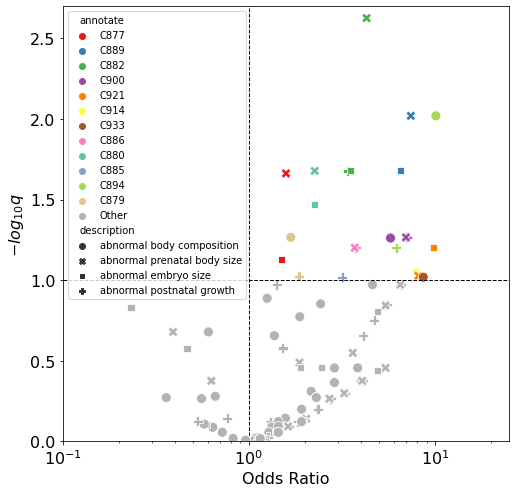

In [225]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=comm_results_body_size, x="OR", y="-log10q", style="description", hue="annotate",
               hue_order=["C877", "C889", "C882", "C900", "C921", "C914","C933", "C886", "C880",
                      "C885", "C894","C879", "Other"],
               legend="brief", palette=my_palette,
               s=100, ax=ax)
plt.xscale("log")
plt.xlabel("Odds Ratio", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("$\minus log_{10}q$", fontsize=16)
plt.vlines(1, 0, 2.7, "black", "dashed", zorder=0, linewidths=1)
plt.hlines(-1 * np.log10(0.1), 0.1, 25, "black", "dashed", linewidths=1)
ax.margins(0)
plt.savefig(FIGDIR+"volcano_with_legend.png", bbox_inches="tight", dpi=400)

## TODO Heatmap?